
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - loss: 0.0643 - val_loss: 0.6399
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 301s 6s/step - loss: 0.0094 - val_loss: 0.5336
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - loss: 0.0066 - val_loss: 0.0439
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/step - loss: 0.0046 - val_loss: 0.0506
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - loss: 0.0040 - val_loss: 0.0345
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - loss: 0.0032 - val_loss: 0.0296
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - loss: 0.0023 - val_loss: 0.0217
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - loss: 0.0091 - val_loss: 0.0223
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - loss: 0.0025 - val_loss: 0.0207
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - loss: 0.0022 - val_loss: 0.0112
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - loss: 0.0020 - val_loss: 0.0102
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/ste

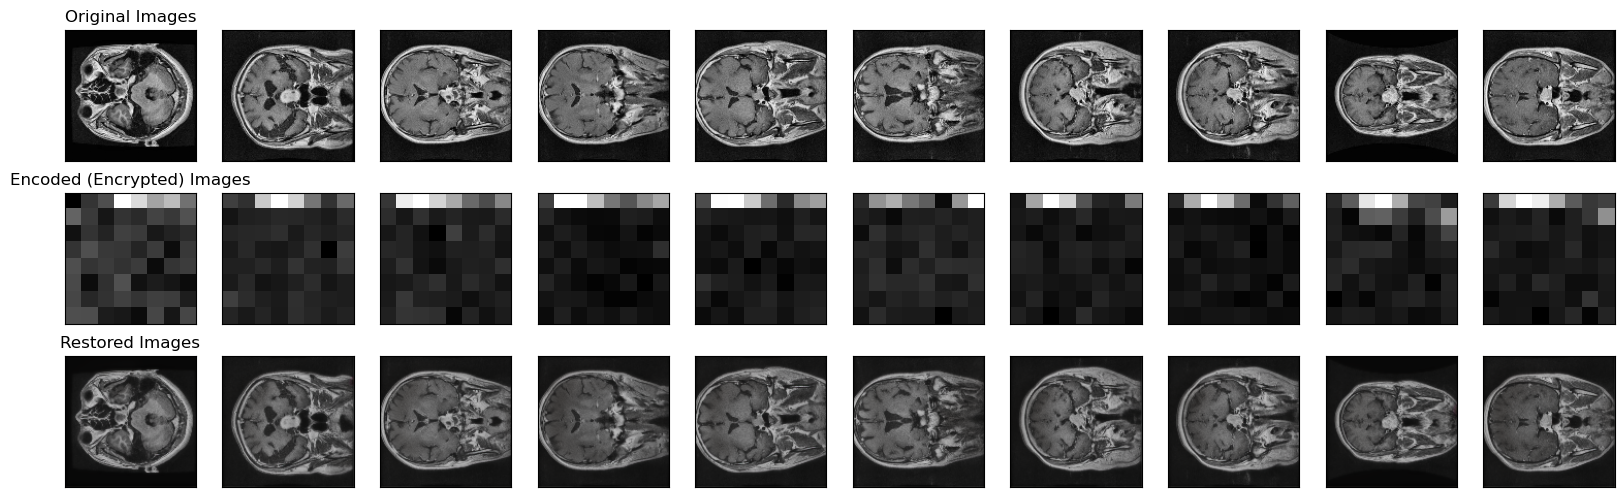

Average SSIM: 0.7995
Average PSNR: 21.6047 dB
Average MSE: 0.0071


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Lambda, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# Function to load and preprocess images
def load_images(directory, target_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            img = load_img(os.path.join(directory, filename), target_size=target_size)
            img = img_to_array(img)
            images.append(img)
    return np.array(images)

# Load brain scan dataset
train_path = 'Downloads/brain_scan/train'
test_path = 'Downloads/brain_scan/test'
valid_path = 'Downloads/brain_scan/valid'

x_train = load_images(train_path)
x_test = load_images(test_path)
x_valid = load_images(valid_path)

# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_valid = x_valid.astype('float32') / 255.

# Define CNN architecture with optimizations
input_img = Input(shape=(128, 128, 3))

# Encoder (Encryption)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.5)(c1)
p1 = MaxPooling2D((2, 2), padding='same')(c1)

c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.5)(c2)
p2 = MaxPooling2D((2, 2), padding='same')(c2)

c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.5)(c3)
p3 = MaxPooling2D((2, 2), padding='same')(c3)

c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.5)(c4)
p4 = MaxPooling2D((2, 2), padding='same')(c4)

encoded = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

# Additional convolutional layers for chaos introduction
chaos = Conv2D(1024, (3, 3), activation='relu', padding='same')(encoded)
chaos = BatchNormalization()(chaos)
chaos = Dropout(0.5)(chaos)

# Function to add statistical mutations (noise)
def add_noise(tensor):
    noise = tf.random.normal(shape=tf.shape(tensor), mean=0.0, stddev=1.0, dtype=tf.float32)  # Increased stddev for more noise
    return tensor + noise

chaos_with_noise = Lambda(add_noise)(chaos)

# Decoder (Restoration) with Skip Connections
u4 = UpSampling2D((2, 2))(chaos_with_noise)
u4 = Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
u4 = BatchNormalization()(u4)
u4 = Dropout(0.5)(u4)
u4 = Concatenate()([u4, c4])

u3 = UpSampling2D((2, 2))(u4)
u3 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
u3 = BatchNormalization()(u3)
u3 = Dropout(0.5)(u3)
u3 = Concatenate()([u3, c3])

u2 = UpSampling2D((2, 2))(u3)
u2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = Dropout(0.5)(u2)
u2 = Concatenate()([u2, c2])

u1 = UpSampling2D((2, 2))(u2)
u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = Dropout(0.5)(u1)
u1 = Concatenate()([u1, c1])

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(u1)  # Output with 3 channels (RGB)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # Optimized for image reconstruction

# Implement early stopping and model checkpoint to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the autoencoder with reduced batch size
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_valid, x_valid),
                callbacks=[early_stopping, model_checkpoint])

# Function to evaluate restoration performance
def evaluate_restoration(x_test, decoded_imgs):
    ssim_scores = []
    psnr_scores = []
    mse_scores = []

    for i in range(len(x_test)):
        original = x_test[i]
        restored = decoded_imgs[i]

        # Calculate SSIM with explicitly set win_size
        try:
            ssim_score = ssim(original, restored, multichannel=True, data_range=1.0, win_size=3)
            ssim_scores.append(ssim_score)
        except ValueError as e:
            print(f"Error calculating SSIM for image {i}: {e}")

        # Calculate PSNR
        psnr_score = psnr(original, restored)
        psnr_scores.append(psnr_score)

        # Calculate MSE
        mse_score = mean_squared_error(original.flatten(), restored.flatten())
        mse_scores.append(mse_score)

    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_mse = np.mean(mse_scores)

    return avg_ssim, avg_psnr, avg_mse

# Encode and decode images
encoder_model = Model(input_img, chaos_with_noise)
encoded_imgs = encoder_model.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# Evaluate restoration performance
avg_ssim, avg_psnr, avg_mse = evaluate_restoration(x_test, decoded_imgs)

# Display original, encoded (encrypted), and restored images for evaluation
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Original Images')

    # Display encoded (encrypted) images (first channel)
    ax = plt.subplot(3, n, i + 1 + n)
    encoded_img_resized = encoded_imgs[i][:, :, 0]  # Selecting the first channel for grayscale display
    plt.imshow(encoded_img_resized, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Encoded (Encrypted) Images')

    # Display restored images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Restored Images')
plt.show()

# Print evaluation metrics
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f} dB')
print(f'Average MSE: {avg_mse:.4f}')
